# Plot terms in the budget of tracer gradient
see *trgrad_budget.ipynb*

In [1]:
clear
homedir = getenv('HOME');
workdir = getenv('WORK');
scradir = getenv('SCRATCH');
campdir = getenv('CAMP');
addpath(genpath([homedir '/work_MOM']));
addpath(genpath([homedir '/mytoolbox']));
addpath(genpath([homedir '/MyFuncs']));

In [2]:
%-------- read model grid
grid_dir = [workdir '/MOM6_exp/mom_lowRES/'];  
[grid, ~, ~] = read_grid_MOM([grid_dir '']); % SOLUTION/
nk = length(grid.Layer);
onesH = ones(grid.nih,grid.njh);
onesU = ones(grid.niu,grid.nju);
onesV = ones(grid.niv,grid.njv);
ik = 1;

%-------- dir for 
tmStr = '_180d';
exp_dir = [workdir '/MOM6_OUT/tr_off_64' tmStr '/'];
h_dir = [workdir '/MOM6_OUT/forc_uvh_64/sol_h' tmStr '/'];   % hL & dhLdt
csflx_dir = [workdir '/MOM6_OUT/forc_uvh_64/uvhm_CS_decomp' tmStr '/'];
csflx_str = 'uvh_mean__';
% 
% tr_dir = [exp_dir 'sols_cfc11/tr_forcprog_addrel10d_norel/'];  
% eforc_dir = [exp_dir 'cforc_cfcrel125d_prog_addreld10/'];
tr_dir = [exp_dir 'sols_pt/tr_forcprog_addrel10d_ptrel/'];  
% tr_dir = [exp_dir 'sols_pt/tr_noforc_ptrel/'];  
eforc_dir = [exp_dir 'cforc_pt_prog_addreld10/'];
% 
tr_varnm = 'tr1';
trtend_varnm = 'tr1_tendency';
eforc_varnm = 'cforc_rel1';
khtr = 100;

% -- for relaxation of the PT tracer
r_relx = 2.9e-8; 
rel_fnm = [workdir '/MOM6_OUT/forc_uvh_64/ICs/trac_init_pt_cs.nc']; % 
c_ref = ncread(rel_fnm,'tr1');
% 
r_relx_h = 2e-8; % 1/s
H1 = 300;
dh = 150;
L_pro = 3840;  %[km]
yf = 3840/2; %[km]
m = 0.1;
[x, y] = deal(grid.geolon-0, grid.geolat-0); %[km]
xy = 2.0 * pi * (m * x - y + yf) / L_pro; 
ifrel = xy > -0.6* 2*pi & xy < 0.6* 2*pi; % all over the domain
href = ifrel.* (H1 + dh*sin(xy));
% 
trIC_fnm = rel_fnm;
cinit3d = ncread(trIC_fnm,'tr1');
% 
% ------ time
yr_s = 21;
dt_flxmean = 6/24;
[day_s, day_e, dt] = deal(1, 365*2, 1); 
t_al = day_s:dt:day_e;
nt_al = length(t_al);
% fprintf(1,'Will do time = Y%s D%s.\n',num2str(yr_s), mat2str(t_al));


## Budget of tracer gradient 
$ \partial_t{c} + \mathbf{u}_L\cdot\nabla{c} = EF/h_L + diffus/h_L + relax/h_L$.  (1) \
Operating on (1) by $[\partial_y{c}\,\partial_y]$ yields \
$\partial_y{c}\partial_t{\partial_y c} + \partial_y{c}\partial_y(\mathbf{u}_L\nabla{c})  = \partial_y{c}\partial_y(EF/h_L) + \partial_y{c}\partial_y(diffus/h_L) + \partial_y{c}\partial_y(relax/h_L)$  (3) 

$\partial_t{(\partial_y c)^2} + 2\partial_y{c}\partial_y(\mathbf{u}_L\cdot\nabla{c})  = 2\partial_y{c}\partial_y(EF/h_L) + 2\partial_y{c}\partial_y(diffus/h_L) + 2\partial_y{c}\partial_y(relax/h_L)$  (4) 

where the second term of (4) can be written as \
$2\partial_y{c}\partial_y(\mathbf{u}_L\cdot\nabla{c}) = \mathbf{u}_L\cdot\nabla{(\partial_y c)^2} + 2\partial_y{c} (\partial_y\mathbf{u}_L\cdot\nabla{c})$


In [3]:
[tend_al, delc_dot_deludelc_al, delc_dot_delEF_al, delc_dot_deldif_al, delc_dot_delrel_al,...
    res_cgrad2_al] = deal(zeros(grid.nih,grid.njh,nt_al));
    
[x, y] = deal(grid.lonh, grid.lath);
% rectangular region in which the delC is averaged
xlims = [0 3000]; ylims = [1600 2400];   % 3000
[~, ii_s] = min(abs(x - xlims(1))); [~, ii_e] = min(abs(x - xlims(2)));
[~, jj_s] = min(abs(y - ylims(1))); [~, jj_e] = min(abs(y - ylims(2)));
[ii, jj] = deal(ii_s:ii_e, jj_s:jj_e);
% [ii, jj] = deal(1:length(x), 1:length(y));

for it = 1:nt_al
    
    %----- time str
    [t1, t2] = deal(t_al(it), t_al(it)+dt_flxmean);
    t15 = (t1 + t2)/2;
    [yrstr_flx, dystr_flx, hrstr_flx] = get_timestr(t15, yr_s); 
    [yrstr, dystr, hrstr] = get_timestr(t2, yr_s); % for k and tracer
    % fprintf(1,'\n time = Y%s-D%s-H%s (it=%d) of %s snapshots ...',...
    %     yrstr,dystr,hrstr,it,num2str(nt_al));
    
    %----- read
    h_fnm = [h_dir 'h_snap__' yrstr '_' dystr '_' hrstr '.nc'];
    tr_fnm = [tr_dir 'tr__' yrstr '_' dystr '_' hrstr '.nc'];
    csflx_fnm = [csflx_dir 'uvh_mean__' yrstr_flx '_' dystr_flx '_' hrstr_flx '.nc'];
    eforc_fnm = [eforc_dir 'forc__' yrstr '_' dystr '_' hrstr '.nc'];
    %
    ds_h = ncstruct(h_fnm);
    ds_tr = ncstruct(tr_fnm);
    ds_csflx = ncstruct(csflx_fnm);
    ds_ef = ncstruct(eforc_fnm);
    %
    c = ds_tr.(tr_varnm)(:,:,ik);
    dcdt = ds_tr.(trtend_varnm)(:,:,ik);
    h = ds_h.h(:,:,ik);
    dhdt = ds_h.dhdt(:,:,ik);
    uh = ds_csflx.uh(:,:,ik) ./ grid.dyCu; % [m2/s]
    vh = ds_csflx.vh(:,:,ik) ./ grid.dxCv; 
    eforc = ds_ef.(eforc_varnm)(:,:,ik); % c*m/s
    % 
    [hu, hv] = p2uv_CG(h, h);
    [u, v] = deal(uh./hu, vh./hv);
    u([1 end],:) = 0; v(:,[1 end]) = 0;
    [uh_p,vh_p] = uv2p_CG(uh,vh);
    [u_p,v_p] = deal(uh_p./h, vh_p./h);
    
    %-- velocity gradient tensor [all on p-grid], [1/s]
    ux = (u(2:end,:) - u(1:end-1,:)) ./ grid.dxT;
    vy = (v(:,2:end) - v(:,1:end-1)) ./ grid.dyT;
    % 
    u_extra = cat(2, zeros(grid.niu,1), u, zeros(grid.niu,1) );
    uy_q = (u_extra(:,2:end) - u_extra(:,1:end-1)) ./ grid.dyBu;
    uy = ( uy_q(1:end-1,1:end-1) + uy_q(1:end-1,2:end) + uy_q(2:end,2:end) + uy_q(2:end,1:end-1) ) / 4;
    v_extra = cat(1, zeros(1,grid.njv), v, zeros(1,grid.njv) );
    vx_q = (v_extra(2:end,:) - v_extra(1:end-1,:)) ./ grid.dxBu;
    vx = ( vx_q(1:end-1,1:end-1) + vx_q(1:end-1,2:end) + vx_q(2:end,2:end) + vx_q(2:end,1:end-1) ) / 4;
    
    %---------- grad of c
    [cx,cy] = calc_GxGy_CG(c,onesH,grid.dxCu,grid.dyCu,grid.dxCv,grid.dyCv,0); % dc/dx [c/m]
    cx([1 end],:) = 0; cy(:,[1 end]) = 0;
    [cx_p,cy_p] = uv2p_CG(cx,cy);
    delc2 = cx_p.^2 + cy_p.^2; % delc * delc
    delc_norm = sqrt(delc2); % |delC|
    %
    [hcx,hcy] = calc_GxGy_CG(c,h,grid.dxCu,grid.dyCu,grid.dxCv,grid.dyCv,0);
    hcx([1 end],:) = 0; hcy(:,[1 end]) = 0;
    % 2nd derivatives: d(c_x)/dx, d(c_y)/dy [c/m^2] p-grid
    cxx = (cx(2:end,:) - cx(1:end-1,:)) ./ grid.dxT;
    cyy = (cy(:,2:end) - cy(:,1:end-1)) ./ grid.dyT;
    
    %------ c-budget terms [m/s*c]
    dchdt = h.* dcdt + dhdt.*c;
    [uhc, vhc] = calc_TFluxes_CG(uh, vh, c, '4th_order');
    divUc = calc_div_CG(uhc, vhc, grid.dyCu,grid.dxCv,grid.dxT,grid.dyT,1);
    % c*div{khtr*del_c}
    [dfu, dfv] = deal(khtr*hcx, khtr*hcy);
    div_diffus = calc_div_CG(dfu, dfv, grid.dyCu,grid.dxCv,grid.dxT,grid.dyT,1); % [c* m/s]
    % relaxation forcing term: c* rh(c*-c)
    if ik == 1
        rforc = r_relx* h.*(c_ref(:,:,ik) - c);
        rforc_h = r_relx_h * (href - h(:,:,ik));
    else
        rforc = 0*c;
        rforc_h = 0*h;
    end
    % 
    divUc_res = -dchdt + eforc + div_diffus + rforc; 
    res_c = dchdt + divUc - eforc - div_diffus - rforc;
    % h-budget terms [m/s]
    divU = calc_div_CG(uh, vh, grid.dyCu,grid.dxCv,grid.dxT,grid.dyT,1);
    res_h = dhdt + divU - rforc_h;
    
    %------ c-budget - adv form [c/s]
    % dcdt + udelc = (eforc + div_diffus + rforc - cRh)./h 
    udelc = (divUc - c.*divU) ./ h;
    cRh = c .* rforc_h ./ h;
    res_cadv = dcdt + udelc + cRh - (eforc + div_diffus + rforc)./h;
    
    %------------------  grad of adv c-budget: x and y components  [c/s/m] ------------------
    %------ 1. grad of dc/dt [c/s/m]
    [dcdt_dx,dcdt_dy] = calc_GxGy_CG(dcdt,onesH,grid.dxCu,grid.dyCu,grid.dxCv,grid.dyCv,0); 
    dcdt_dx([1 end],:) = 0; dcdt_dy(:,[1 end]) = 0;
    
    %------ 2. del_{u * delC} [c/s/m]
    [udelc_dx,udelc_dy] = calc_GxGy_CG(udelc,onesH,grid.dxCu,grid.dyCu,grid.dxCv,grid.dyCv,0); 
    udelc_dx([1 end],:) = 0; udelc_dy(:,[1 end]) = 0;
    
    %------ 3. del_{EF/h} [c/s/m], p-
    [EF_dx,EF_dy] = calc_GxGy_CG(eforc./h,onesH,grid.dxCu,grid.dyCu,grid.dxCv,grid.dyCv,0); 
    EF_dx([1 end],:) = 0; EF_dy(:,[1 end]) = 0;
    
    %------ 4. del pf diffus, relax (both c and h)
    [dif_dx,dif_dy] = calc_GxGy_CG(div_diffus./h,onesH,grid.dxCu,grid.dyCu,grid.dxCv,grid.dyCv,0); 
    dif_dx([1 end],:) = 0; dif_dy(:,[1 end]) = 0;
    [rel_dx,rel_dy] = calc_GxGy_CG(cRh-rforc./h,onesH,grid.dxCu,grid.dyCu,grid.dxCv,grid.dyCv,0); 
    rel_dx([1 end],:) = 0; rel_dy(:,[1 end]) = 0;
    
    %------ res
    res_cgrad_x = dcdt_dx + udelc_dx - EF_dx - dif_dx - rel_dx;
    res_cgrad_y = dcdt_dy + udelc_dy - EF_dy - dif_dy - rel_dy;

    %------------------  eqn of {c_y}^2  [c2/m2/s], p- ------------------
    %------ 1. dcdy * dy of dc/dt
    [cx_dot_dcdt_dx, cy_dot_dcdt_dy] = deal(cx .* dcdt_dx, cy .* dcdt_dy);
    
    %------ 2. dcdy * dy_{u * delC}
    [cx_dot_udelc_dx, cy_dot_udelc_dy] = deal(cx .* udelc_dx, cy .* udelc_dy);
    %-- a). u * del{cy^2/2}
    [cy2_dx,cy2_dy] = calc_GxGy_CG(cy_p.^2,onesH,grid.dxCu,grid.dyCu,grid.dxCv,grid.dyCv,0); 
    cy2_dx([1 end],:) = 0; cy2_dy(:,[1 end]) = 0;
    [u_dot_cy2_dx, v_dot_cy2_dy] = deal(u .* cy2_dx, v .* cy2_dy);
    %-- b). (del{u} * del{c}) * del{c} = ux*cx^2 + (uy+vx)*cx*cy + uy*cy^2
    
    %------ 3. del{c} * del_{EF/h}
    [cx_dot_EF_dx, cy_dot_EF_dy] = deal(cx .* EF_dx, cy .* EF_dy);
    
    %------ 4. del{c} * del_{diffus/h} + del{c} * del_{relax/h}
    [cx_dot_dif_dx, cy_dot_dif_dy] = deal(cx .* dif_dx, cy .* dif_dy);
    [cx_dot_rel_dx, cy_dot_rel_dy] = deal(cx .* rel_dx, cy .* rel_dy);
    
    %------ average terms onto p-point
    [cx_dot_dcdt_dx_p, cy_dot_dcdt_dy_p]   = uv2p_CG(cx_dot_dcdt_dx, cy_dot_dcdt_dy);
    [cx_dot_udelc_dx_p, cy_dot_udelc_dy_p] = uv2p_CG(cx_dot_udelc_dx, cy_dot_udelc_dy);
        [u_dot_cy2_dx_p, v_dot_cy2_dy_p] = uv2p_CG(u_dot_cy2_dx, v_dot_cy2_dy);
    [cx_dot_EF_dx_p, cy_dot_EF_dy_p]       = uv2p_CG(cx_dot_EF_dx, cy_dot_EF_dy);
    [cx_dot_dif_dx_p, cy_dot_dif_dy_p]     = uv2p_CG(cx_dot_dif_dx, cy_dot_dif_dy);
    [cx_dot_rel_dx_p, cy_dot_rel_dy_p]     = uv2p_CG(cx_dot_rel_dx, cy_dot_rel_dy);
    % 
    tend = 2* (0 + cy_dot_dcdt_dy_p);
    delc_dot_deludelc = 2* (0 + cy_dot_udelc_dy_p);
        %-- opt 1
        u_dot_deldelc2 = u_dot_cy2_dx_p + v_dot_cy2_dy_p;
        % u_dot_deldelc2 = u_p .* delc2_dx_p + v_p .* delc2_dy_p;
        delu_delc_delc = delc_dot_deludelc - u_dot_deldelc2;
        %-- opt 2
        % delu_delc_delc = 2* (ux.*cx_p.^2 + (uy+vx).*cx_p.*cy_p + uy.*cy_p.^2);
        % u_dot_deldelc2 = delc_dot_deludelc - delu_delc_delc;
    delc_dot_delEF  = 2* (0 + cy_dot_EF_dy_p);
    delc_dot_deldif = 2* (0 + cy_dot_dif_dy_p);
    delc_dot_delrel = 2* (0 + cy_dot_rel_dy_p);
    res_cgrad2 = tend + delc_dot_deludelc - delc_dot_delEF - delc_dot_deldif - delc_dot_delrel;

    %------------------ save
    tend_al(:,:,it) = tend;
    delc_dot_deludelc_al(:,:,it) = delc_dot_deludelc;
        u_dot_deldelc2_al(:,:,it) = u_dot_deldelc2; 
        delu_delc_delc_al(:,:,it) = delu_delc_delc;
    delc_dot_delEF_al(:,:,it) = delc_dot_delEF;
    delc_dot_deldif_al(:,:,it) = delc_dot_deldif;
    delc_dot_delrel_al(:,:,it) = delc_dot_delrel;
    res_cgrad2_al(:,:,it) = res_cgrad2;

    %------------------ rms
    % res_cadv = dcdt + udelc + cRh - (eforc + div_diffus + rforc)./h;
    % rms_tend(it) = rms(dcdt(ii,jj),'all','omitnan');
    % rms_L(it) = rms(udelc(ii,jj),'all','omitnan');
    % rms_E(it) = rms(eforc./h,'all','omitnan');
    % rms_A(it) = rms(div_diffus./h,'all','omitnan');
    % rms_R(it) = rms(cRh - rforc./h,'all','omitnan');
    % rms_res(it) = rms(res_cadv(ii,jj),'all','omitnan');
    
    rms_tend(it) = rms(tend(ii,jj),'all','omitnan');
    rms_L(it) = rms(delc_dot_deludelc(ii,jj),'all','omitnan');
        rms_Ladv(it) = rms(u_dot_deldelc2(ii,jj),'all','omitnan');
        rms_Lcon(it) = rms(delu_delc_delc(ii,jj),'all','omitnan');
    rms_E(it) = rms(delc_dot_delEF(ii,jj),'all','omitnan');
    rms_A(it) = rms(delc_dot_deldif(ii,jj),'all','omitnan');
    rms_R(it) = rms(delc_dot_delrel(ii,jj),'all','omitnan');
    rms_res(it) = rms(res_cgrad2(ii,jj),'all','omitnan');

    %------------------ mean
    mean_tend(it) = mean(tend(ii,jj),'all','omitnan');
    mean_L(it) = mean(delc_dot_deludelc(ii,jj),'all','omitnan');
        mean_Ladv(it) = mean(u_dot_deldelc2(ii,jj),'all','omitnan');
        mean_Lcon(it) = mean(delu_delc_delc(ii,jj),'all','omitnan');
    mean_E(it) = mean(delc_dot_delEF(ii,jj),'all','omitnan');
    mean_A(it) = mean(delc_dot_deldif(ii,jj),'all','omitnan');
    mean_R(it) = mean(delc_dot_delrel(ii,jj),'all','omitnan');
    mean_res(it) = mean(res_cgrad2(ii,jj),'all','omitnan');
    
end

## time smooth $\chi_{\parallel}$

In [4]:
t_dim = 2;
win_dy = 5; % window len in [day]
win_hf = (win_dy/dt) / 2; % # of data points in half of the window (even)
% 
% rms_dcdtdy_sld = movmean(rms_dcdtdy, [win_hf, win_hf], t_dim);
% rms_udelc_dy_sld = movmean(rms_udelc_dy, [win_hf, win_hf], t_dim);
% rms_dyu_delc_sld = movmean(rms_dyu_delc, [win_hf, win_hf], t_dim);
% rms_u_ddelcdy_sld = movmean(rms_u_ddelcdy, [win_hf, win_hf], t_dim);
% rms_dy_EF_sld = movmean(rms_dy_EF, [win_hf, win_hf], t_dim);
% rms_dy_diffusrel_sld = movmean(rms_dy_diffusrel, [win_hf, win_hf], t_dim);
% rms_res_sld = movmean(rms_res, [win_hf, win_hf], t_dim);
% rms_dcdtdy_fromres_sld = movmean(rms_dcdtdy_fromres, [win_hf, win_hf], t_dim);
% 
mean_tend_sld = movmean(mean_tend, [win_hf, win_hf], t_dim);
mean_L_sld = movmean(mean_L, [win_hf, win_hf], t_dim);
    mean_Ladv_sld = movmean(mean_Ladv, [win_hf, win_hf], t_dim);
    mean_Lcon_sld = movmean(mean_Lcon, [win_hf, win_hf], t_dim);
mean_E_sld = movmean(mean_E, [win_hf, win_hf], t_dim);
mean_A_sld = movmean(mean_A, [win_hf, win_hf], t_dim);
mean_R_sld = movmean(mean_R, [win_hf, win_hf], t_dim);
mean_res_sld = movmean(mean_res, [win_hf, win_hf], t_dim);


## get GS core

In [5]:
ds_GS = load('GScore_mom_unsm_wide.mat');
x_GSC_m = ds_GS.x_GSC_m;
y_GSC_m = ds_GS.y_GSC_m;

# plot

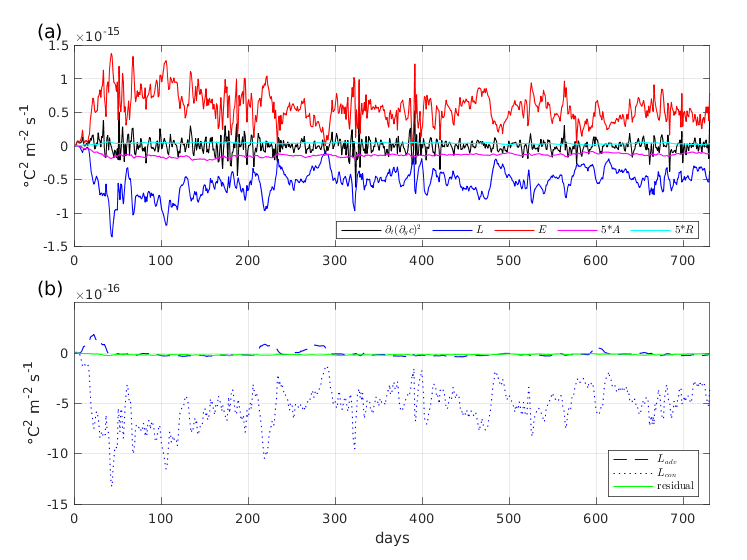

In [6]:
% 
% denom = rms(mean_dcdtdy_fromres_sld,'omitnan');
% [~, id] = max(abs(mean_udelc_dy_sld)); % fromres_
% denom = abs( mean_udelc_dy_sld(id) );
% corrcoef(-mean_udelc_dy, mean_EF_dy,'rows','complete')
% corrcoef(-mean_u_ddelcdy, -mean_dyu_delc,'rows','complete')

denom = 1;

% fplt1_al = {mean_tend_sld ./ denom, -mean_L_sld ./ denom, mean_E_sld ./ denom ...
%         , 5*mean_A_sld ./ denom, 5*mean_R_sld ./ denom}; 
fplt1_al = {mean_tend ./ denom, -mean_L ./ denom, mean_E ./ denom ...
        , 5*mean_A ./ denom, 5*mean_R ./ denom}; 
% titles1 = {'$\partial_t{\partial_y c}$', '$-\partial_y(\mathbf{u}_L\cdot\nabla{c})$', ...
%     '$\partial_y(EF/h_L)$', 'diffusion', '5*relaxation'};
titles1 = {'$\partial_t(\partial_y{c})^2$', '$L$', '$E$', '5*$A$', '5*$R$'};
styles1 = {'k-', 'b-', 'r-', 'm-', 'c-'};

% fplt2_al = {mean_dcdtdy_sld ./ denom, mean_dif_dy ./ denom};%mean_dy_diffusrel_fromres
% titles2 = {'$\partial_t{\partial_y c}$', '$\partial_t{\partial_y c} +\partial_y(\mathbf{u}_L\cdot\nabla{c})-\partial_y(EF/h_L)$'};
% styles2 = {'k-', 'c-', 'c-', 'c--'};
% fplt2_al = {-mean_Ladv_sld ./ denom, -mean_Lcon_sld ./ denom, mean_res_sld ./ denom};
fplt2_al = {-mean_Ladv ./ denom, -mean_Lcon ./ denom, mean_res ./ denom};
% titles2 = {'$-\mathbf{u}_L\cdot\partial_y\nabla{c}$', '$-\partial_y\mathbf{u}_L\cdot\nabla{c}$'...
%         'residual'};
titles2 = {'$L_{adv}$', '$L_{con}$'...
    'residual'};
styles2 = {'b--', 'b:', 'g-', 'c--', 'c:'};

% ------ plot
font = 'DejaVu Sans';
figure('DefaultTextFontName', font, 'DefaultAxesFontName', font);
[ha, ~] = tight_subplot(2,1,[.1 .05],[.1 .08],[.10 .05]);

ylim = [-1 1]*1e1;
axes(ha(1))
ncel = numel(fplt1_al);
for icel = 1:ncel
    f_do = fplt1_al{icel};
    plot(t_al,f_do,styles1{icel},'linewidth',.8); 
    hold on
    % titles1{icel} = [titles1{icel} ' (t-mean=' num2str(mean(f_do,'omitnan'),'%3.2f') ')'];
end
set(gca,'xlim',[0 t_al(end)],'xgrid','on','ygrid','on'); % 'ylim',ylim,
legend(titles1,'location','southeast','interpreter','latex','fontsize',8,'NumColumns',5)
% title('Region mean')
ylabel('\circC^2 m^{-2} s^{-1}')

% 
ylim = [-1.5e-15 .5e-15];
axes(ha(2))
ncel = numel(fplt2_al);
for icel = 1:ncel
    f_do = fplt2_al{icel};
    plot(t_al,f_do,styles2{icel},'linewidth',.8); 
    hold on
    % titles2{icel} = [titles2{icel} ' (t-mean=' num2str(mean(f_do,'omitnan'),'%3.2f') ')'];
end
set(gca,'xlim',[0 t_al(end)],'ylim',ylim,'xgrid','on','ygrid','on');
legend(titles2,'location','southeast','interpreter','latex','fontsize',8,'NumColumns',1)
xlabel('days')
ylabel('\circC^2 m^{-2} s^{-1}')

hb = subplotlabel(gcf,'a','location','northwestoutside','offset',[-0.06 0.01],'Prefix','(','Postfix',')','fontsize',14);
set(gcf,'PaperPositionMode','auto'); 

% ---
fignm = [homedir '/work_MOM/figures/fig7_cy2budget_2yr'];
% exportgraphics(gcf,[fignm '.pdf'], 'BackgroundColor','white','ContentType','vector')

## Correlations

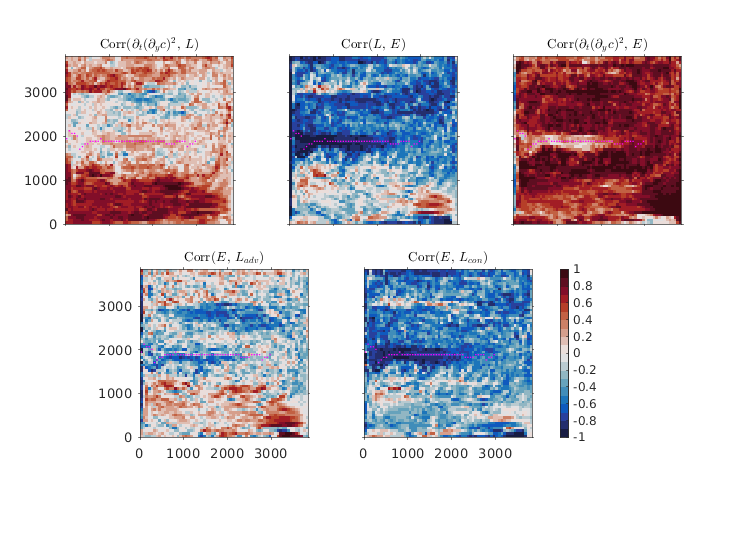

In [7]:
[x, y] = deal(grid.lonh, grid.lath);

it_cor = 1:nt_al;
nlevels = 20;
clim = [-1 1];
fontsz = 10;

x_top = 0.05; y_top = 0.6; h_top = 0.3; w_top = h_top; dx_bot = 0.0003;
x_bot = 0.15; y_bot = 0.22; h_bot = h_top; w_bot = h_top; dx_bot = 0.0003; 
% 
pos_top = { [x_top y_top w_top h_top], [x_top+w_top y_top w_top h_top], [x_top+2*w_top y_top w_top h_top]};
pos_bot = { [x_bot y_bot w_bot h_bot], [x_bot+w_bot+dx_bot y_bot w_bot h_bot] };

    
% ------------ plot ------------
font = 'DejaVu Sans';
figure('DefaultTextFontName', font, 'DefaultAxesFontName', font);

% ----- top - 3 subplots
% --- top-1
[f1, f2] = deal( tend_al(:,:,it_cor), -delc_dot_deludelc_al(:,:,it_cor) ); 
[f1, f2] = deal( squeeze(f1), squeeze(f2) );
corr2d = corr_array(f1,f2,3);
% 
subplot('Position',pos_top{1});
imagescn(x, y, corr2d'); axis square; set(gca,'tickdir','out');
set(gca,'xticklabel','')
caxis(clim);
cmap = cmocean('balance',nlevels);
colormap(cmap);
title('$\textrm{Corr}(\partial_t(\partial_y{c})^2 ,\, L )$', 'Interpreter','latex','fontsize',fontsz)
hold on; scatter(x_GSC_m, y_GSC_m, 10,'.m')

% --- top-2
[f1, f2] = deal( -delc_dot_deludelc_al(:,:,it_cor), delc_dot_delEF_al(:,:,it_cor) ); 
[f1, f2] = deal( squeeze(f1), squeeze(f2) );
corr2d = corr_array(f1,f2,3);
subplot('Position',pos_top{2});
imagescn(x, y, corr2d'); axis square; set(gca,'tickdir','out');
set(gca,'xticklabel','','yticklabel','')
caxis(clim); 
cmap = cmocean('balance',nlevels);
colormap(cmap);
title('$\textrm{Corr}(L,\, E)$', 'Interpreter','latex','fontsize',fontsz)
hold on; scatter(x_GSC_m, y_GSC_m, 10,'.m')

% --- top-3
[f1, f2] = deal( tend_al(:,:,it_cor), delc_dot_delEF_al(:,:,it_cor) ); 
[f1, f2] = deal( squeeze(f1), squeeze(f2) );
corr2d = corr_array(f1,f2,3);
subplot('Position',pos_top{3});
imagescn(x, y, corr2d'); axis square; set(gca,'tickdir','out');
set(gca,'xticklabel','','yticklabel','')
caxis(clim); 
cmap = cmocean('balance',nlevels);
colormap(cmap);
title('$\textrm{Corr}(\partial_t(\partial_y{c})^2 ,\, E)$',...
    'Interpreter','latex','fontsize',fontsz)
hold on; scatter(x_GSC_m, y_GSC_m, 10,'.m')

% ------- bot - 2 subplots
% --- bot-1
[f1, f2] = deal( delc_dot_delEF_al(:,:,it_cor), -u_dot_deldelc2_al(:,:,it_cor) ); 
[f1, f2] = deal( squeeze(f1), squeeze(f2) );
corr2d = corr_array(f1,f2,3);
subplot('Position',pos_bot{1});
imagescn(x, y, corr2d'); axis square; set(gca,'tickdir','out');
% set(gca,'xticklabel','','yticklabel','')
caxis(clim); 
cmap = cmocean('balance',nlevels);
colormap(cmap);
title('$\textrm{Corr}(E,\, L_{adv} )$',...
    'Interpreter','latex','fontsize',fontsz)
hold on; scatter(x_GSC_m, y_GSC_m, 10,'.m')

% --- bot-2
[f1, f2] = deal( delc_dot_delEF_al(:,:,it_cor), -delu_delc_delc_al(:,:,it_cor) ); 
[f1, f2] = deal( squeeze(f1), squeeze(f2) );
corr2d = corr_array(f1,f2,3);
subplot('Position',pos_bot{2});
imagescn(x, y, corr2d'); axis square; set(gca,'tickdir','out');
set(gca,'yticklabel','')
caxis(clim); 
cmap = cmocean('balance',nlevels);
colormap(cmap);
title('$\textrm{Corr}(E,\, L_{con} )$',...
    'Interpreter','latex','fontsize',fontsz)
hold on; scatter(x_GSC_m, y_GSC_m, 10,'.m')

% ------
cb = colorbar;
cb.XTick = clim(1):.2:clim(2);
cb.Position = [0.75 y_bot 0.01 0.3];
set(gcf,'PaperPositionMode','auto'); 

% ---
fignm = [homedir '/work_MOM/figures/fig8_corr_cy2budget'];
% exportgraphics(gcf,[fignm '.pdf'], 'BackgroundColor','white','ContentType','vector')